In [1]:
import numpy as np
import scipy as sp
import sympy as sy
import cmath

In [2]:
import matplotlib.pyplot as plt

In [3]:
import qutip as qt
from qnet.algebra.hilbert_space_algebra import *
from qnet.algebra.operator_algebra import *
from qnet.algebra.circuit_algebra import *

Using QNET to compute the series product, $ G_{T} =G \triangleleft M $

In [4]:
#kappa=symbols("kappa", real=True)
omega=symbols("omega", real=True)
tls = local_space('tls', basis=('e', 'g') )
sigma = LocalSigma(tls, 'g', 'e')
sigmaz=LocalProjector('e', 'tls') - LocalProjector('g', 'tls')
S_g=identity_matrix(2)
L1_g=sigma
L2_g = 0
L_g = Matrix([[L1_g], \
              [L2_g]])
H_g=0
G=SLH(S_g, L_g, H_g).toSLH()

S_h=identity_matrix(2)
L1_h=sigma
L2_h = 0
L_h = Matrix([[L1_h], \
              [L2_h]])
H_h=omega*sigmaz
M=SLH(S_h, L_h, H_h).toSLH()
G_T=SeriesProduct(M,G)
G_T = G_T.toSLH()
G_T

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[ScalarTimesOperator(2, LocalSigma(LocalSpace('tls', ''), 'g', 'e'))], [ZeroOperator]]), ScalarTimesOperator(omega, OperatorPlus(LocalSigma(LocalSpace('e', ''), 'tls', 'tls'), ScalarTimesOperator(-1, LocalSigma(LocalSpace('g', ''), 'tls', 'tls')))))

In [5]:
params = {omega :1.0545718*10**-34*90*10**9}
G_T_num = G_T.substitute(params)

In the next couple of code cells belpw we are implementing the extended system filtering equation i.e.
$$
\begin{aligned}
G_{T} &=G \triangleleft M \\
&=\left(S, L+\frac{\xi(t)}{\sqrt{w(t)}} S \sigma_{-}, H+\frac{\xi(t)}{\sqrt{w(t)}} \operatorname{Im}\left(L^{\dagger} S \sigma_{-}\right)\right)
\end{aligned}
$$
With the ancilla and system SLH parameters being, $G= \left(I, \lambda(t) \sigma_{-},  0 \right) $ and  $M= \left(I, \sqrt\kappa \sigma_{-},  \omega_0\sigma_{z} \right) $
which is interpreted as  
$$
\begin{aligned}
G_{T} &=\left(I \otimes I, I\otimes\sqrt\kappa+ \lambda(t)\sigma_{-} \otimes I, I \otimes \omega_{0}\sigma_{z}\right)
\end{aligned}
$$
The code cell immediately below is implementing wavepacket shape $\xi(t)= \sqrt\beta \exp (-(\beta-i\omega_0))$ for t $>$ 0 [1]     and the time dependent coefficient $\lambda(t)+\sqrt\kappa$ of the combined system collapse operator by the python functions "epsilon_t" and "col_coeff" respectively.  Where $\lambda(t)=\frac{1}{\sqrt{w(t)}} \xi(t)$ and $w(t)=\int_{t}^{\infty}|\xi(s)|^{2} d s$.  
\
[1]: [arXiv:1902.10961] Guofeng Zhang, Control of continuous-mode single-photon states: a review 

In [8]:
import scipy.integrate as integrate

beta = 61*10**6
omega_0 =1*10**9
k= 0.02*10**6
times = np.linspace(1, 16, 301)

def epsilon_t (t,args):
    x=complex(-beta/2, omega_0)*times
    return np.sqrt(beta)*np.exp(x)

def col_coeff(t, args):
    times1=np.linspace(1, t, 301)
    e=complex(-beta/2, omega_0)*times1
    d=np.sqrt(beta)*np.exp(e)
    b=abs(d)**2
    f=complex(-beta/2, omega_0)*t
    g=np.sqrt(beta)*np.exp(f)
    x=complex(-beta/2, omega_0)*times
    z=np.sqrt(beta)*np.exp(x)
    c=abs(z)**2
    N= integrate.simpson(c, times) 
    w = integrate.simpson(b, times1)/N
    l=(g/np.sqrt(w))+np.sqrt(k)
    return l

Below is the qutip implementation of the extended system filter: $$
\begin{aligned}
d \tilde{\pi}_{t}(A \otimes X)=& \tilde{\pi}_{t}\left(\mathcal{L}_{G_{T}}(A \otimes X)\right) d t \\
&+\left(\tilde{\pi}_{t}\left(A \otimes X L_{T}+L_{T}^{\dagger} A \otimes X\right)\right.\\
&\left.-\tilde{\pi}_{t}\left(L_{T}+L_{T}^{\dagger}\right) \tilde{\pi}_{t}(A \otimes X)\right) d W(t)
\end{aligned}
$$
for an arbitrary ancilla + system operator, $y=A \otimes X=\sigma_{x} \otimes \sigma_{z}\ $, 
$S_{T}= I \otimes I$, $L_{T}=I\otimes\sqrt\kappa\sigma_{-}+ \lambda(t)\sigma_{-} \otimes I$ and $H_{T}=I \otimes \omega_{0}\sigma_{z}$ with initial state being $ \left\rvert\psi\right\rangle= \left\rvert1\right\rangle \otimes \left\rvert0\right\rangle $ with $\left\rvert0\right\rangle=\begin{pmatrix}
  0 \\ 
  1 
\end{pmatrix} $ and $\left\rvert1\right\rangle= \begin{pmatrix}
  1 \\ 
  0 
\end{pmatrix}$

In [9]:
psi = qt.tensor(qt.basis(2,1),qt.basis(2,0))
rho0 = qt.ket2dm(psi) 
H=qt.tensor(qt.qeye(2), qt.sigmaz())
c_ops=[qt.tensor(qt.qeye(2), np.sqrt(0.5)*qt.sigmam()),[qt.tensor(qt.qeye(2),qt.sigmam()), col_coeff]]
sc_ops=[qt.tensor(qt.qeye(2), np.sqrt(0.5)*qt.sigmam()),[qt.tensor(qt.qeye(2),qt.sigmam()), col_coeff]]
y=qt.Qobj(qt.tensor(qt.sigmax(),qt.sigmaz()))
#y=qt.Qobj(qt.tensor(qt.qeye(2),qt.sigmaz())+qt.tensor(qt.sigmax(),qt.qeye(2)))
opt = qt.Options()
opt.store_states = True
nsubsteps = 50
result = qt.smesolve(H, rho0, times, c_ops=c_ops,
                  sc_ops=sc_ops, e_ops=[y], ntraj=100, nsubsteps=nsubsteps, solver="taylor15",
                  method='homodyne', store_measurement=True)

c:\users\rupay\appdata\local\programs\python\python39\lib\site-packages\scipy\integrate\_quadrature.py:414: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
c:\users\rupay\appdata\local\programs\python\python39\lib\site-packages\scipy\integrate\_quadrature.py:416: RuntimeWarning: invalid value encountered in true_divide
  y[slice1] * (hsum * hsum / hprod) +
C:\Users\rupay\AppData\Local\Temp/ipykernel_18392/2507341613.py:24: RuntimeWarning: invalid value encountered in cdouble_scalars
  l=(g/np.sqrt(w))+np.sqrt(k)
C:\Users\rupay\AppData\Local\Temp/ipykernel_18392/2507341613.py:23: RuntimeWarning: invalid value encountered in double_scalars
  w = integrate.simpson(b, times1)/N


10.0%. Run time: 1898.83s. Est. time left: 00:04:44:49
20.0%. Run time: 3754.66s. Est. time left: 00:04:10:18
30.0%. Run time: 5602.58s. Est. time left: 00:03:37:52
40.0%. Run time: 7097.77s. Est. time left: 00:02:57:26
50.0%. Run time: 8928.35s. Est. time left: 00:02:28:48
60.0%. Run time: 10836.91s. Est. time left: 00:02:00:24
70.0%. Run time: 12693.08s. Est. time left: 00:01:30:39
80.0%. Run time: 14423.12s. Est. time left: 00:01:00:05
90.0%. Run time: 15963.66s. Est. time left: 00:00:29:33
Total run time: 17469.46s


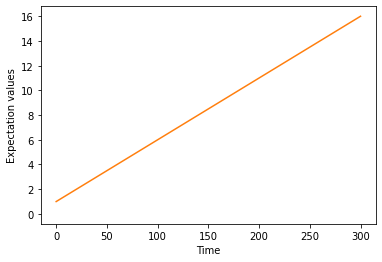

In [10]:
plt.figure()
plt.plot(times, result.expect[0], times)
plt.title('')
plt.xlabel('Time')
plt.ylabel('Expectation values')
plt.show()

In [11]:
pwd

'C:\\Users\\rupay'